<a href="https://colab.research.google.com/github/Benned-H/Summer2019/blob/master/HandsFree%20Vision/Coding_Full_Process.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This will be a full run-through of the hand segmentation process defined in "Hand Segmentation Using Skin Color and Background Information" and "A New Method for Hand Segmentation Using Free-Form Skin Color Model."

**Process for defining our color model**
1. Obtain image of hand.
2. Crop image so that our sample contains *only* pixels of skin color.
3. Convert result into our color space, YCbCr.
4. Plot all pixels in skin sample in CbCr plane, a 255x255 result.
5. Dilate and erode this result to smooth out the free-form skin model.
6. Perform edge point extraction to define boundary.
7. Use Sobel operator with gradient edge detection to create final skin color cluster.

In [1]:
# 1. Obtain image of hand.
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import os
os.chdir("gdrive/My Drive/Colab Notebooks/HandsFree/Photos")

In [3]:
!ls

Ashley.png  Office.jpg	Seth.png    Tiger.png
GWB.png     Office.png	Steven.png  Wesley.png


<class 'numpy.ndarray'>
(317, 568, 3)


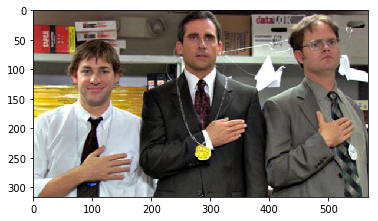

In [4]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread("Office.png")
plt.imshow(img)

# We have a 317x568 RGB image as a numpy array.
print(type(img))
print(img.shape)

In [0]:
# 2. Crop image so that our sample contains only pixels of skin color.
import numpy as np
img_copy = np.copy(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


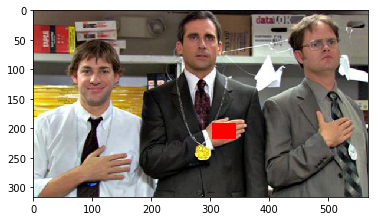

In [6]:
# Manually found these coordinates to zoom into Michael's hand.
bb_r = 192
bb_c = 304
bb_h = 27
bb_w = 40
img_copy[bb_r:bb_r+bb_h,bb_c:bb_c+bb_w] = [255,0,0]
plt.imshow(img_copy)

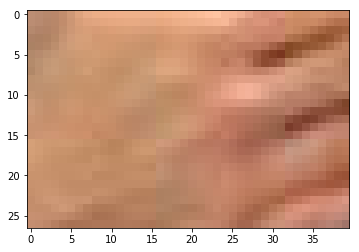

In [7]:
sample = np.zeros((bb_h,bb_w,3)) # Create RGB array for cropped image.
for r in range(sample.shape[0]):
  for c in range(sample.shape[1]):
    sample[r][c] = img[bb_r+r][bb_c+c]
    
plt.imshow(sample)

In [0]:
# 3. Convert result into our color space, YCbCr.
def RGB_to_YCbCr(image):
  # Converts a given RGB image to the YCbCr color space.
  if len(image[0,0]) != 3:
    print("Error: Image is not RGB.")
    return
  output = np.zeros((image.shape[0],image.shape[1],3))
  for r in range(image.shape[0]):
    for c in range(image.shape[1]):
      rgb = image[r,c]
      output[r,c,0] =  0.2568*rgb[0] + 0.5041*rgb[1] + 0.0979*rgb[2] + 0.0625
      output[r,c,1] = -0.1482*rgb[0] - 0.2910*rgb[1] + 0.4392*rgb[2] + 0.5
      output[r,c,2] =  0.4392*rgb[0] - 0.3678*rgb[1] - 0.0714*rgb[2] + 0.5
  
  output = output * 256 # Convert into clean 0-255 range.
  return output.astype(np.int64)

def RGB_to_YCbCr_Matrix(image):
  # Matrix version of the method.
  if len(image[0,0]) != 3:
    print("Error: Image is not RGB.")
    return
  
  transform = np.array([[0.2568,0.5041,0.0979],
                        [-0.1482,-0.2910,0.4392],
                        [0.4392,-0.3678,-0.0714]])
  output = np.zeros((image.shape[0],image.shape[1],3))
  for r in range(image.shape[0]):
    for c in range(image.shape[1]):
      rgb = image[r,c]
      output[r,c] = np.matmul(transform,rgb) + [0.0625,0.5,0.5]
  
  output = output * 256 # Convert into clean 0-255 range.
  return output.astype(np.int64)

2.7215068340301514


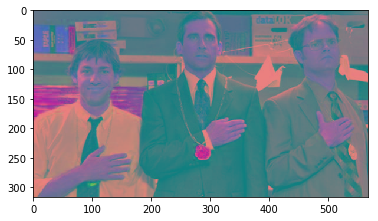

In [9]:
# As an example, here's the full image in YCbCr:
import time

start = time.time()
exampleYCbCr = RGB_to_YCbCr(img)
end = time.time()
print(end-start)
    
plt.imshow(exampleYCbCr)

0.6877908706665039


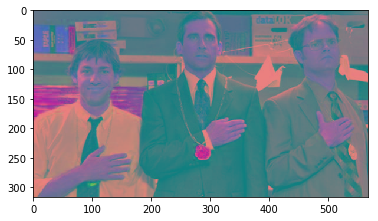

In [10]:
start = time.time()
exampleMatrix = RGB_to_YCbCr_Matrix(img)
end = time.time()
print(end-start)
    
plt.imshow(exampleMatrix)

In [11]:
# The two functions give the same result, which is good.
print(img[0,0])
print(exampleYCbCr[0,0])
print(exampleMatrix[0,0])

[0.45882353 0.38431373 0.3254902 ]
[103 118 137]
[103 118 137]


Clearly, the matrix transformation seems like the way to go for the YCbCr conversion. Later experimentation confirmed this observation, although an in-depth study has not been completed. If the issue remains a bottleneck, I'll look into this function's implementation more thoroughly. As another note, *we could probably chop off the Y calculation entirely and save some computation there.*

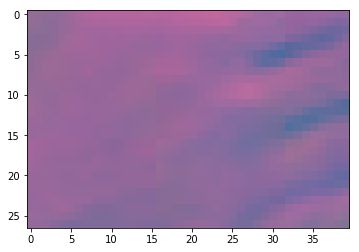

In [12]:
sample = np.zeros((bb_h,bb_w,3))
for r in range(bb_h):
  for c in range(bb_w):
    sample[r,c] = img[bb_r+r,bb_c+c]

michael_hand = RGB_to_YCbCr_Matrix(sample)
plt.imshow(michael_hand)

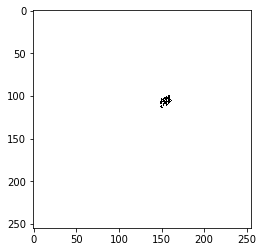

In [13]:
# 4. Plot all pixels in skin sample in CbCr plane, a 255x255 result.
michael_plane = np.zeros((255,255))

for r in range(michael_hand.shape[0]):
  for c in range(michael_hand.shape[1]):
    cb = michael_hand[r,c][1]
    cr = michael_hand[r,c][2]
    michael_plane[cb,cr] = 1
    
plt.imshow(michael_plane, cmap='Greys')

In [0]:
# 5. Dilate and erode this result to smooth out the free-form skin model.
def splitKernel(kernel):
  """Splits given kernel into individual offsets from its center.
  Also gives maximum offsets in order left right up down."""
    
  if not isinstance(kernel, np.ndarray):
    print("Error: Invalid kernel. Need numpy array")
    return None
  
  # Require 2D array.
  if len(kernel.shape) != 2:
    print("Error: Invalid kernel. Need 2D array")
    return None
  
  height = kernel.shape[0]
  width = kernel.shape[1]
  
  # Require odd dimensions on kernel. Input pixel at center.
  if (height % 2 != 1) or (width % 2 != 1):
    print("Error: Invalid kernel. Need odd dimensions")
    return None
  
  center_r = int(height) // 2
  center_c = int(width) // 2
  outputs = []
  
  # Loop over all pixels
  for r in range(height):
    for c in range(width):
      if kernel[r][c] == 1:
        outputs.append((r - center_r, c - center_c))
        
  return outputs

def maxOffsets(offsets):
  # Do this to avoid if statements on all input pixels.
  left = 0
  right = 0
  up = 0
  down = 0
  
  # Find max offset in each direction.
  for o in offsets:
    left = max(left, -o[1])
    right = max(right, o[1])
    up = max(up, -o[0])
    down = max(down, o[0])
    
  return left,right,up,down

def dilate(image, kernel, times=1):
  """Dilate the given image using the given kernel.
  Note: Only uses binary images/kernel."""
  
  # Split the kernel into individual offset coordinates.
  kernel_parts = splitKernel(kernel)
  
  # Fetch the maximum offsets from any input pixel in our kernel.
  left,right,up,down = maxOffsets(kernel_parts)
  
  output = np.zeros(image.shape)
  
  # Main part of image checking, no if statements needed:
  for r in range(0 + up, image.shape[0] - down):
    for c in range(0 + left, image.shape[1] - right):
      for k in kernel_parts:
        curr_r = r + k[0]
        curr_c = c + k[1]
        if image[curr_r][curr_c] == 1:
          output[r][c] = 1
          
  # Now cover four sides and corners:
  
  # Left side:
  for r in range(0 + up, image.shape[0] - down):
    for c in range(0, left):
      for k in kernel_parts:
        curr_r = r + k[0]
        curr_c = c + k[1]
        if curr_c >= 0:
          if image[curr_r][curr_c] == 1:
            output[r][c] = 1
            
  # Right side:
  for r in range(0 + up, image.shape[0] - down):
    for c in range(image.shape[1] - right, image.shape[1]):
      for k in kernel_parts:
        curr_r = r + k[0]
        curr_c = c + k[1]
        if curr_c < image.shape[1]:
          if image[curr_r][curr_c] == 1:
            output[r][c] = 1
  
  # Top side:
  for r in range(0, up):
    for c in range(0 + left, image.shape[1] - right):
      for k in kernel_parts:
        curr_r = r + k[0]
        curr_c = c + k[1]
        if curr_r >= 0:
          if image[curr_r][curr_c] == 1:
            output[r][c] = 1
            
  # Bottom side:
  for r in range(image.shape[0] - down, image.shape[0]):
    for c in range(0 + left, image.shape[1] - right):
      for k in kernel_parts:
        curr_r = r + k[0]
        curr_c = c + k[1]
        if curr_r < image.shape[0]:
          if image[curr_r][curr_c] == 1:
            output[r][c] = 1
  
  # Left top corner:
  for r in range(0, up):
    for c in range(0, left):
      for k in kernel_parts:
        curr_r = r + k[0]
        curr_c = c + k[1]
        if curr_r >= 0 and curr_c >= 0:
          if image[curr_r][curr_c] == 1:
            output[r][c] = 1
          
  # Right top corner:
  for r in range(0, up):
    for c in range(image.shape[1] - right, image.shape[1]):
      for k in kernel_parts:
        curr_r = r + k[0]
        curr_c = c + k[1]
        if curr_r >= 0 and curr_c < image.shape[1]:
          if image[curr_r][curr_c] == 1:
            output[r][c] = 1
            
  # Left bottom corner:
  for r in range(image.shape[0] - down, image.shape[0]):
    for c in range(0, left):
      for k in kernel_parts:
        curr_r = r + k[0]
        curr_c = c + k[1]
        if curr_r < image.shape[0] and curr_c >= 0:
          if image[curr_r][curr_c] == 1:
            output[r][c] = 1
            
  # Right bottom corner:
  for r in range(image.shape[0] - down, image.shape[0]):
    for c in range(image.shape[1] - right, image.shape[1]):
      for k in kernel_parts:
        curr_r = r + k[0]
        curr_c = c + k[1]
        if curr_r < image.shape[0] and curr_c < image.shape[1]:
          if image[curr_r][curr_c] == 1:
            output[r][c] = 1
            
  if times > 1:
    return dilate(output, kernel, times-1)
  return output

def erode(image, kernel, times=1):
  """Erode the given image using the given kernel.
  Note: Only uses binary images/kernel."""
  
  # Split the kernel into individual offset coordinates.
  kernel_parts = splitKernel(kernel)
  
  # Fetch the maximum offsets from any input pixel in our kernel.
  left,right,up,down = maxOffsets(kernel_parts)
  
  output = np.ones(image.shape)
  
  # Main part of image checking, no if statements needed:
  for r in range(up, image.shape[0] - down):
    for c in range(left, image.shape[1] - right):
      for k in kernel_parts:
        curr_r = r + k[0]
        curr_c = c + k[1]
        if image[curr_r][curr_c] == 0:
          output[r][c] = 0
          
  # Now cover four sides and corners:
  
  # Left side:
  for r in range(0 + up, image.shape[0] - down):
    for c in range(0, left):
      for k in kernel_parts:
        curr_r = r + k[0]
        curr_c = c + k[1]
        if curr_c >= 0:
          if image[curr_r][curr_c] == 0:
            output[r][c] = 0
            
  # Right side:
  for r in range(0 + up, image.shape[0] - down):
    for c in range(image.shape[1] - right, image.shape[1]):
      for k in kernel_parts:
        curr_r = r + k[0]
        curr_c = c + k[1]
        if curr_c < image.shape[1]:
          if image[curr_r][curr_c] == 0:
            output[r][c] = 0
  
  # Top side:
  for r in range(0, up):
    for c in range(0 + left, image.shape[1] - right):
      for k in kernel_parts:
        curr_r = r + k[0]
        curr_c = c + k[1]
        if curr_r >= 0:
          if image[curr_r][curr_c] == 0:
            output[r][c] = 0
            
  # Bottom side:
  for r in range(image.shape[0] - down, image.shape[0]):
    for c in range(0 + left, image.shape[1] - right):
      for k in kernel_parts:
        curr_r = r + k[0]
        curr_c = c + k[1]
        if curr_r < image.shape[0]:
          if image[curr_r][curr_c] == 0:
            output[r][c] = 0
  
  # Left top corner:
  for r in range(0, up):
    for c in range(0, left):
      for k in kernel_parts:
        curr_r = r + k[0]
        curr_c = c + k[1]
        if curr_r >= 0 and curr_c >= 0:
          if image[curr_r][curr_c] == 0:
            output[r][c] = 0
          
  # Right top corner:
  for r in range(0, up):
    for c in range(image.shape[1] - right, image.shape[1]):
      for k in kernel_parts:
        curr_r = r + k[0]
        curr_c = c + k[1]
        if curr_r >= 0 and curr_c < image.shape[1]:
          if image[curr_r][curr_c] == 0:
            output[r][c] = 0
            
  # Left bottom corner:
  for r in range(image.shape[0] - down, image.shape[0]):
    for c in range(0, left):
      for k in kernel_parts:
        curr_r = r + k[0]
        curr_c = c + k[1]
        if curr_r < image.shape[0] and curr_c >= 0:
          if image[curr_r][curr_c] == 0:
            output[r][c] = 0
            
  # Right bottom corner:
  for r in range(image.shape[0] - down, image.shape[0]):
    for c in range(image.shape[1] - right, image.shape[1]):
      for k in kernel_parts:
        curr_r = r + k[0]
        curr_c = c + k[1]
        if curr_r < image.shape[0] and curr_c < image.shape[1]:
          if image[curr_r][curr_c] == 0:
            output[r][c] = 0
  
  if times > 1:
    return erode(output, kernel, times-1)
  return output

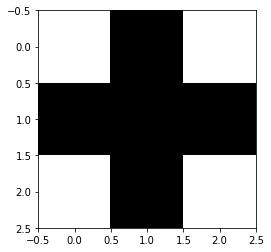

In [15]:
kernel_cross = np.array([[0,1,0],[1,1,1],[0,1,0]])
kernel_3x3 = np.array([[1,1,1],[1,1,1],[1,1,1]])
kernel_1x1 = np.array([[1]])
plt.imshow(kernel_cross, cmap='Greys')

Two dilations with the cross kernel seem to have about the same impact as one with the box kernel, except the box loses definition and seems to round out edges more than I'd like.

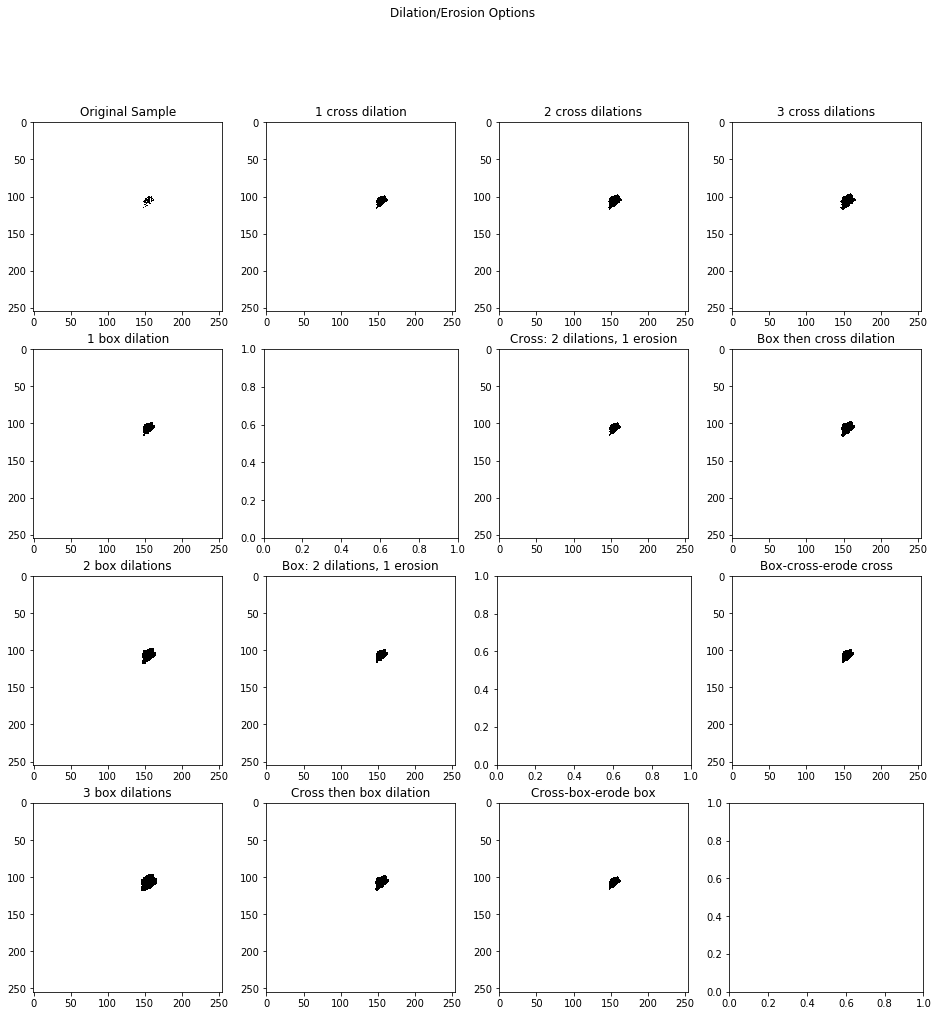

In [16]:
fig, axs = plt.subplots(4,4,figsize=(16,16))
fig.suptitle('Dilation/Erosion Options')
    
one_box = dilate(michael_plane, kernel_3x3)
two_box = dilate(one_box, kernel_3x3)
three_box = dilate(two_box, kernel_3x3)

one_cross = dilate(michael_plane, kernel_cross)
two_cross = dilate(one_cross, kernel_cross)
three_cross = dilate(two_cross, kernel_cross)

two_one_box = erode(two_box, kernel_3x3)
two_one_cross = erode(two_cross, kernel_cross)

box_cross = dilate(one_box, kernel_cross)
cross_box = dilate(one_cross, kernel_3x3)
bcec = erode(box_cross, kernel_cross)
cbeb = erode(cross_box, kernel_3x3)

axs[0,0].imshow(michael_plane,cmap='Greys')
axs[0,0].title.set_text("Original Sample")
axs[0,1].imshow(one_cross,cmap='Greys')
axs[0,1].title.set_text("1 cross dilation")
axs[1,0].imshow(one_box,cmap='Greys')
axs[1,0].title.set_text("1 box dilation")

axs[0,2].imshow(two_cross,cmap='Greys')
axs[0,2].title.set_text("2 cross dilations")
axs[0,3].imshow(three_cross,cmap='Greys')
axs[0,3].title.set_text("3 cross dilations")
axs[2,0].imshow(two_box,cmap='Greys')
axs[2,0].title.set_text("2 box dilations")
axs[3,0].imshow(three_box,cmap='Greys')
axs[3,0].title.set_text("3 box dilations")

axs[1,2].imshow(two_one_cross,cmap='Greys')
axs[1,2].title.set_text("Cross: 2 dilations, 1 erosion")
axs[2,1].imshow(two_one_box,cmap='Greys')
axs[2,1].title.set_text("Box: 2 dilations, 1 erosion")

axs[1,3].imshow(box_cross,cmap='Greys')
axs[1,3].title.set_text("Box then cross dilation")
axs[3,1].imshow(cross_box,cmap='Greys')
axs[3,1].title.set_text("Cross then box dilation")
axs[2,3].imshow(bcec,cmap='Greys')
axs[2,3].title.set_text("Box-cross-erode cross")
axs[3,2].imshow(cbeb,cmap='Greys')
axs[3,2].title.set_text("Cross-box-erode box")

I think the 2-1-box and 2-1-cross results look promising, and the box-cross-erode or box-cross-erode-erode might also be useful. Also worth considering is how much time the operation takes: a box dilation or erosion has eight operations compared to the cross' four. Maybe this will make a difference at runtime?

Box dilation 50x: 14.504855632781982


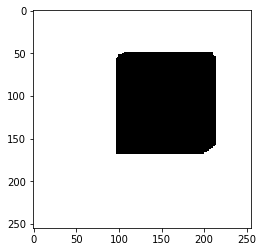

In [0]:
# Takes about 15sec, don't worry about lack of output.
start = time.time()
result = dilate(michael_plane, kernel_3x3)

for i in range(50):
  result = dilate(result, kernel_3x3)
    
end = time.time()
print("Box dilation 50x:", end-start)
plt.imshow(result, cmap="Greys")

In [57]:
start = time.time()
result = dilate(michael_plane, kernel_cross)

for i in range(50):
  result = dilate(result, kernel_cross)
    
end = time.time()
print("Cross dilation 50x:", end-start)
plt.imshow(result, cmap="Greys")

KeyboardInterrupt: ignored

As suspected, the cross dilation is almost twice as fast, although both methods could be improved by optimizing the kernel take-apart outside of the function. Regardless, we're only dilating during the color map creation and thus this difference will be negligable on the overall project's runtime. As for:   
6. Perform edge point extraction to define boundary.   

7. Use Sobel operator with gradient edge detection to create final skin color cluster.   


Both of these steps aren't really necessary, as we can just check if individual pixels are in the color model's palette.

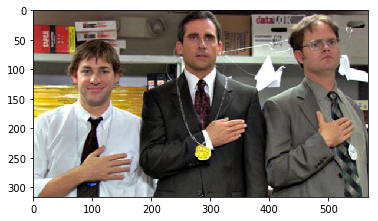

In [17]:
# Let's perform some actual segmentation.
plt.imshow(img)

In [0]:
def segment(image, plane):
  # Segments the given hand colors within the given RGB image.
  ycbcr = RGB_to_YCbCr_Matrix(image)
  output = np.zeros(image.shape)
  for r in range(output.shape[0]):
    for c in range(output.shape[1]):
      cb = ycbcr[r,c][1]
      cr = ycbcr[r,c][2]
      if plane[cb,cr] == 1:
        output[r,c] = 1
  return output

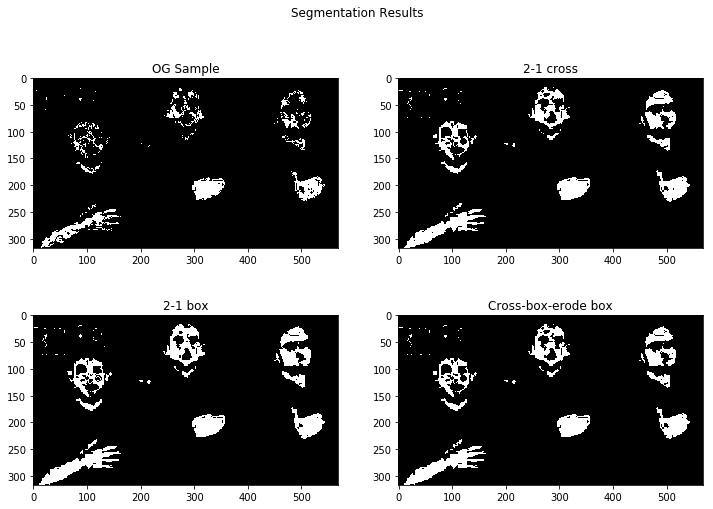

In [56]:
fig, axs = plt.subplots(2,2,figsize=(12,8))
fig.suptitle('Segmentation Results')
    
og_sample = segment(img,michael_plane)
two1cross = segment(img,two_one_cross)
two1box = segment(img,two_one_box)
combo = segment(img,cbeb)

axs[0,0].imshow(og_sample,cmap='Greys')
axs[0,0].title.set_text("OG Sample")
axs[0,1].imshow(two1cross,cmap='Greys')
axs[0,1].title.set_text("2-1 cross")
axs[1,0].imshow(two1box,cmap='Greys')
axs[1,0].title.set_text("2-1 box")
axs[1,1].imshow(combo,cmap='Greys')
axs[1,1].title.set_text("Cross-box-erode box")

## Testing this workflow

I used an online random celebrity generator and then picked the first picture on Google Images with each celebrity's hand in-frame. Let's test on these:

In [28]:
!ls

Ashley.png  Office.jpg	Seth.png    Tiger.png
GWB.png     Office.png	Steven.png  Wesley.png


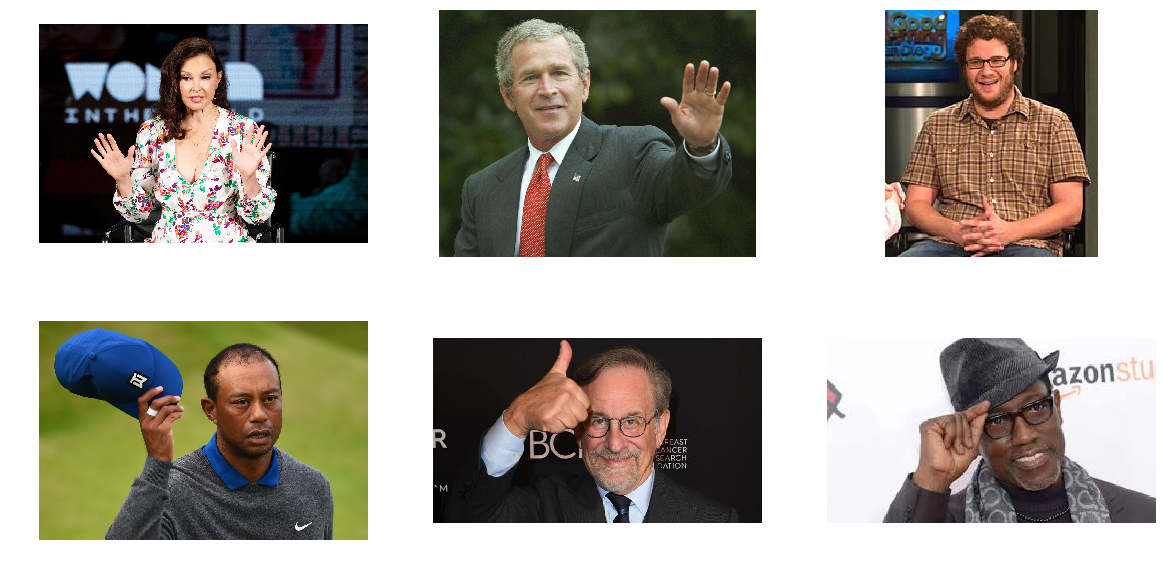

In [29]:
ashley = mpimg.imread("Ashley.png")
gwb = mpimg.imread("GWB.png")
seth = mpimg.imread("Seth.png")
tiger = mpimg.imread("Tiger.png")
steven = mpimg.imread("Steven.png")
wesley = mpimg.imread("Wesley.png")

examples = [ashley,gwb,seth,tiger,steven,wesley]
boxes = [np.zeros(4)] * len(examples) # Will store r,c,h,w.

fig, axs = plt.subplots(2,3,figsize=(20,10))
for r in range(axs.shape[0]):
  for c in range(axs.shape[1]):
    e = examples[r*3 + c]
    axs[r,c].axis('off')
    axs[r,c].imshow(e)

In [0]:
# Had to hand-specify these coordinates, but this won't be an issue in my RaspPi program - Much easier through UI there.
boxes[0] = [1100,550,100,200]
boxes[1] = [575,1550,225,200]
boxes[2] = [183,75,25,25]
boxes[3] = [375,395,100,75]
boxes[4] = [100,220,80,90]
boxes[5] = [80,90,35,35]

In [0]:
def previewBoxes(examples,boxes):
  fig, axs = plt.subplots(2,3,figsize=(20,10))
  
  for r in range(axs.shape[0]):
    for c in range(axs.shape[1]):
      axs[r,c].axis('off')
      e = r * axs.shape[1] + c # Number of example in list.
      example_copy = np.copy(examples[e])
      box = boxes[e]
      example_copy[int(box[0]):int(box[0]+box[2]),int(box[1]):int(box[1]+box[3])] = [255,0,0]
      axs[r,c].imshow(example_copy)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


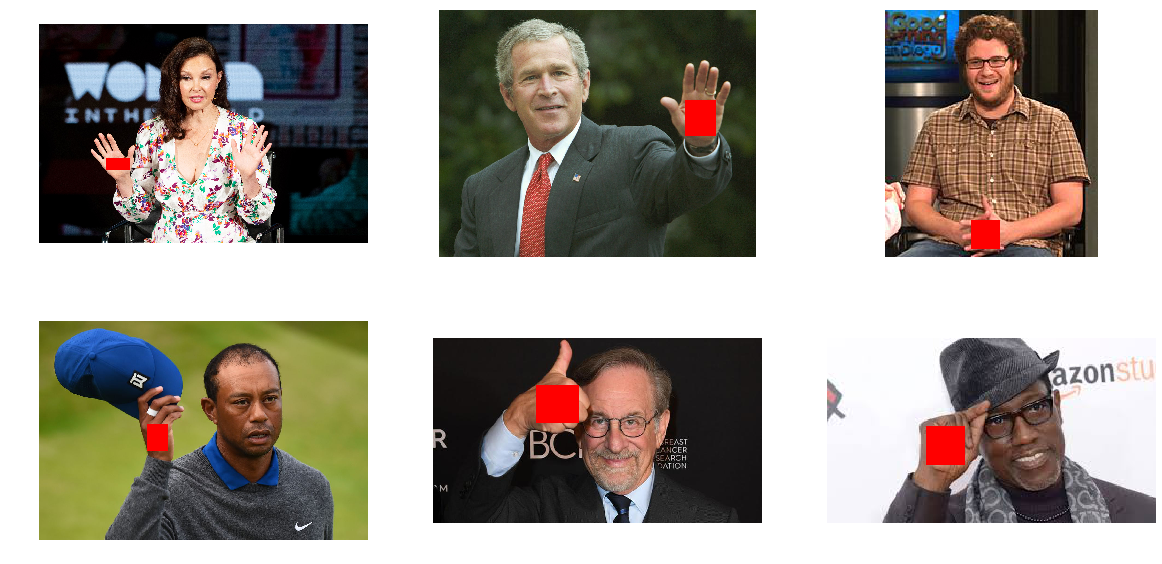

In [32]:
previewBoxes(examples,boxes)

In [0]:
def previewSamples(examples,boxes):
  fig, axs = plt.subplots(2,3,figsize=(20,10))
  samples = []
  
  for r in range(axs.shape[0]):
    for c in range(axs.shape[1]):
      axs[r,c].axis('off')
      e = r * axs.shape[1] + c # Number of example in list.
      box = boxes[e]
      img = examples[e]
      
      sample = np.zeros((box[2],box[3],3)) # Create RGB array for cropped image.
      
      for b_r in range(sample.shape[0]):
        for b_c in range(sample.shape[1]):
          sample[b_r][b_c] = img[box[0]+b_r][box[1]+b_c]
          
      axs[r,c].imshow(sample)
      samples.append(sample)
  return samples

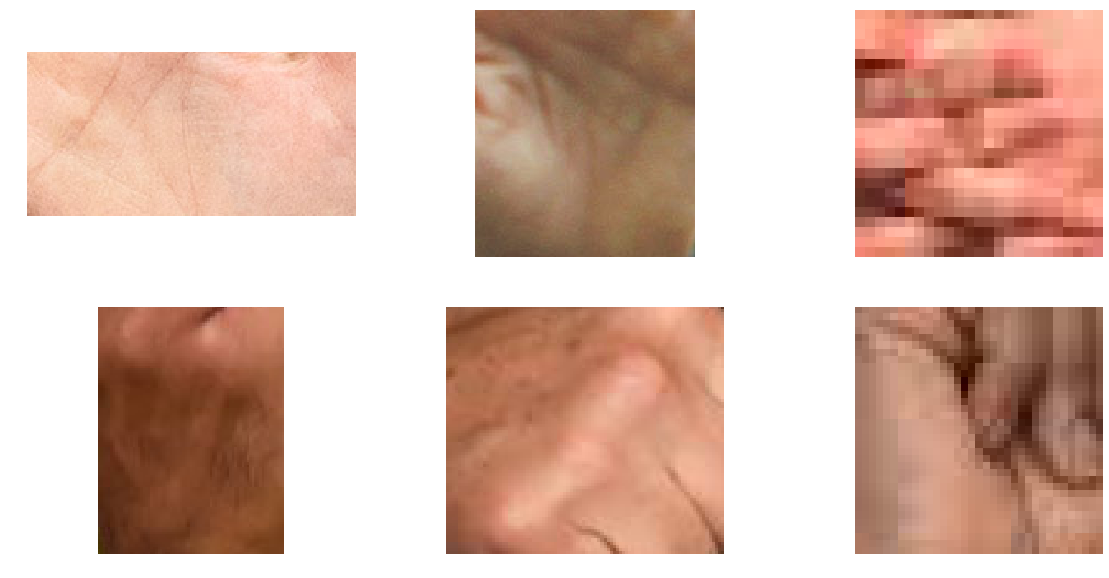

In [34]:
# These pictures look weird, but also look like valid skin samples from hands.
samples = previewSamples(examples,boxes)

In [39]:
total = 0
ycbcr_samples = []
for s in samples:
  start = time.time()
  ycbcr_samples.append(RGB_to_YCbCr(s))
  end = time.time()
  total += (end-start)

print("Traditional method:", total)

total2 = 0
ycbcr_samples2 = []
for s in samples:
  start = time.time()
  ycbcr_samples2.append(RGB_to_YCbCr_Matrix(s))
  end = time.time()
  total2 += (end-start)

print("Matrix method:", total2)

Traditional method: 0.2069103717803955
Matrix method: 0.2862679958343506


In [40]:
# Just to confirm that the matrix function is faster on larger images.
start = time.time()
output = RGB_to_YCbCr(examples[2])
output = RGB_to_YCbCr(examples[4])
output = RGB_to_YCbCr(examples[5])
end = time.time()
print("Traditional method:", end-start)

start = time.time()
output = RGB_to_YCbCr_Matrix(examples[2])
output = RGB_to_YCbCr_Matrix(examples[4])
output = RGB_to_YCbCr_Matrix(examples[5])
end = time.time()
print("Matrix method:", end-start)

Traditional method: 5.544995069503784
Matrix method: 1.3822860717773438


In [0]:
planes = []

for sample in ycbcr_samples:
  plane = np.zeros((255,255))
  for r in range(sample.shape[0]):
    for c in range(sample.shape[1]):
      cb = sample[r,c][1]
      cr = sample[r,c][2]
      plane[cb,cr] = 1
  planes.append(plane)

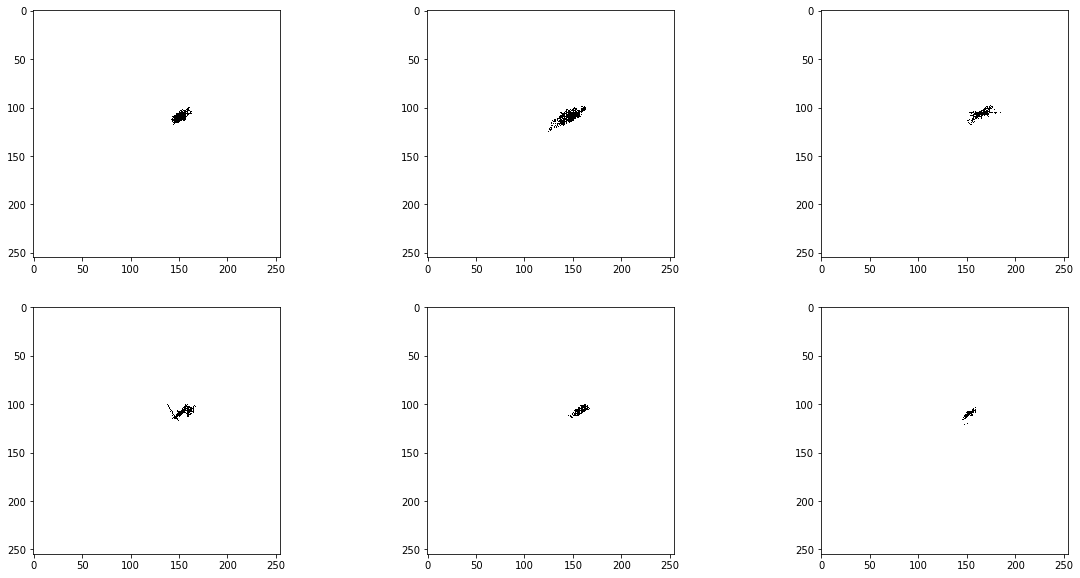

In [45]:
fig, axs = plt.subplots(2,3,figsize=(20,10))
for r in range(axs.shape[0]):
  for c in range(axs.shape[1]):
    p = planes[r*3 + c]
    #axs[r,c].axis('off')
    axs[r,c].imshow(p,cmap="Greys")

In [0]:
# We could also write a method that directly takes the samples boxes and outputs pre-dilated color planes. That's far more elegant.
def createPlane(image,box):
  ycbcr = RGB_to_YCbCr_Matrix(image)
  plane = np.zeros((255,255))
  
  for r in range(box[0],box[0]+box[2]): # Only scan pixels in the box.
    for c in range(box[1],box[1]+box[2]): # Only scan pixels in the box.
      cb = ycbcr[r,c][1]
      cr = ycbcr[r,c][2]
      plane[cb,cr] = 1
      
  # Uses the box-cross-erode-cross morphological edit, we could change this easily.
  plane = dilate(plane, kernel_cross)
  plane = dilate(plane, kernel_3x3)
  plane = erode(plane, kernel_cross)
  return plane

# While we're at it, here's the whole process in one method.
def segmentFull(image,box):
  plane = createPlane(image,box)
  return segment(image,plane)

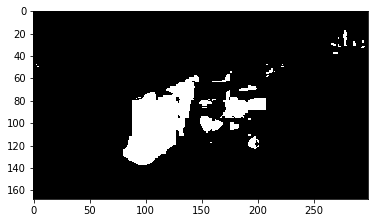

In [67]:
plt.imshow(segmentFull(examples[5],boxes[5]))